# Delayed Luggage Distribution with optimum number of vehicles

## Problem Description

A small company with six vans has a contract with a number of airlines to pick up lost or delayed baggage, belonging to customers in the London area, from Heathrow airport at 6 p.m. each evening. The contract stipulates that each customer must have their baggage delivered by 8 p.m. The company requires a model to advise them what is the minimum number of vans they need to use and to which customers each van should deliver and in what order. There is no practical capacity limitation on each van. Each van can hold all baggage that needs to be delivered in a two-hour period. To solve this problem, we can formulate an optimization model that minimizes the number of vans that need to be used.

(example 27 from the fifth edition of Model Building in Mathematical Programming by H. Paul Williams)

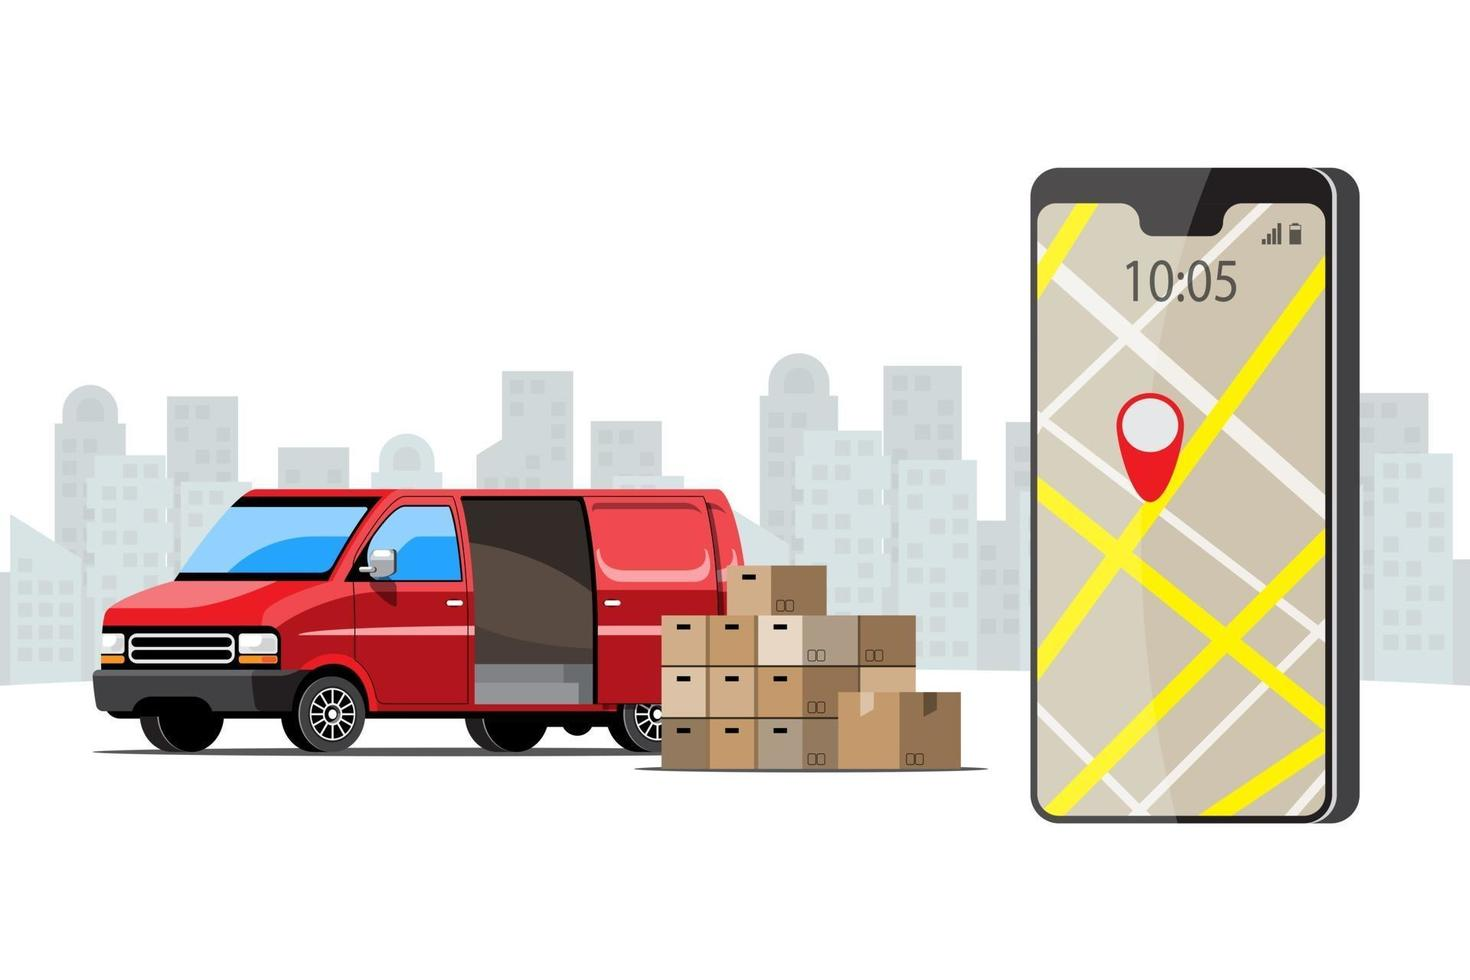

##  Model Formulation


### Sets and Indices

$i,j \in \text{Locations} \equiv L=\{0,1..(n-1)\}$: Set of locations where $0$ is the index for the single depot -Heathrow airport, and $n$ is the number of locations.

$k \in \text{Vans} \equiv  V=\{0..K-1\}$: Index and set of vans, where $K$ is the number of vans.

$S_k \in S  $: Tour of van $k$, i.e. subset of locations visited by the van.

### Parameters

$t_{i,j} \in \mathbb{R}^+$: Travel time from location $i$  to location $j$.

### Decision Variables

$x_{i,j,k} \in \{0,1 \}$: This binary variable is equal 1, if van $k$ visits and goes directly from location $i$ to location $j$, and zero otherwise.

$y_{i,k} \in \{0,1 \}$: This binary variable is equal 1, if van $k$ visits location $i$, and zero otherwise.

$z_{k} \in \{0,1 \}$: This binary variable is equal 1, if van $k \in \{1,2..K\}$ is used, and zero otherwise.

### Objective Function

**Number of vans**: Minimize number of vans used.

\begin{equation}
\text{Minimize} \quad \sum_{k = 1}^{K} z_k
\end{equation}

### Constraints

**Van utilization**: For all locations different from the depot, i.e. $i > 0$, if the location is visited by van $k$, then it is used.

\begin{equation}
y_{i,k} \leq z_{k} \quad \forall i \in L \setminus \{0\}, \; k \in V
\end{equation}

**Travel time**: No van travels for more than 120 min. Note that we do not consider the travel time to return to the depot.

\begin{equation}
\sum_{i \in L} \sum_{j \in L \setminus \{0\}} t_{i,j} \cdot x_{i,j,k} \leq 120 \quad \forall k \in  V
\end{equation}

**Visit all customers**:  Each customer location is visited by exactly one van.

\begin{equation}
\sum_{k \in V}  y_{i,k} = 1 \quad \forall i \in L \setminus \{0\}
\end{equation}

**Depot**: Heathrow is visited by every van used. 

\begin{equation}
\sum_{k \in V}  y_{1,k} \geq \sum_{k \in V} z_k
\end{equation}

**Arriving at a location**: If location $j$ is visited by van $k$, then the van is coming from another location $i$.

\begin{equation}
\sum_{i \in L}  x_{i,j,k} =  y_{j,k}  \quad \forall j \in L, \; k \in V
\end{equation}

**Leaving a location**: If van $k$ leaves location $j$, then the van is going to another location $i$.

\begin{equation}
\sum_{i \in L}  x_{j,i,k} = y_{j,k}  \quad \forall j \in L, \; k \in V
\end{equation}

**Breaking symmetry**: 

\begin{equation}
\sum_{i \in L}  y_{i,k} \geq \sum_{i \in L}  y_{i,k+1} \quad \forall k \in  \{0..K-1\}
\end{equation}

**Subtour elimination**: These constraints ensure that for each van route, there is no cycle. 

\begin{equation}
\sum_{(i,j) \in S_k}x_{i,j,k} \leq |S_k|-1 \quad \forall  k \in K, \;   S_k \subseteq L
\end{equation}


### Input Data

I have assumed following input data, for developing this model.
* number of locations, including the depot = 17, depot is indexed with 0
* number of vans = 6
* speed of vans = 60 km/hr (ie 1km/min , travel time = distance, this is to make the model simple)
* locations : cordinates are selected randomly


In [2]:
import sys
import math
import random
from itertools import permutations
import gurobipy as gp
from gurobipy import GRB

In [3]:
n = 17
locations = [*range(n)] 
K = 6
vans = [*range(K)]
random.seed(1)
points = [(0, 0)]# depot at (0,0)
points += [(random.randint(0, 50), random.randint(0, 50)) for i in range(n-1)] 
time = {(i, j):
        math.sqrt(sum((points[i][k]-points[j][k])**2 for k in range(2)))
        for i in locations for j in locations if i != j} #eucledian distance is considered to calculate the distance between two locations



### Decision Varibales
decision variables determines the order in which each van visits a subset of custormers, which customer is visited by each van, and if a van is used or not.

In [5]:
m = gp.Model('lost_luggage_distribution.lp')
x = m.addVars(time.keys(), vans, vtype=GRB.BINARY, name='FromToBy') #x =1, if van  k  visits and goes directly from location  i  to location  j
y = m.addVars(locations, vans, vtype=GRB.BINARY, name='visitBy') # y = 1, if customer i is visited by van k
z = m.addVars(vans, vtype=GRB.BINARY, name='used')# Number of vans used 
t = m.addVars(vans, ub=120, name='travelTime')# Travel time per van
s = m.addVar(name='maxTravelTime')# maximum travel time

Set parameter Username
Academic license - for non-commercial use only - expires 2022-04-04


In [6]:
visitCustomer = m.addConstrs((y[i,k] <= z[k]  for k in vans for i in locations if i > 0), name='visitCustomer' )#van use constraint
travelTime = m.addConstrs((gp.quicksum(time[i,j]*x[i,j,k] for i,j in time.keys() if j > 0) == t[k] for k in vans), 
                          name='travelTimeConstr' ) 

In [7]:
visitAll = m.addConstrs((y.sum(i,'*') == 1 for i in locations if i > 0), name='visitAll' )
depotConstr = m.addConstr(y.sum(0,'*') >= z.sum(), name='depotConstr' )
ArriveConstr = m.addConstrs((x.sum('*',j,k) == y[j,k] for j,k in y.keys()), name='ArriveConstr' )

LeaveConstr = m.addConstrs((x.sum(j,'*',k) == y[j,k] for j,k in y.keys()), name='LeaveConstr' )
breakSymm = m.addConstrs((y.sum('*',k-1) >= y.sum('*',k) for k in vans if k>0), name='breakSymm' )
maxTravelTime = m.addConstrs((t[k] <= s for k in vans), name='maxTravelTimeConstr')

### Objective Function


In [8]:
m.ModelSense = GRB.MINIMIZE
m.setObjectiveN(z.sum(), 0, priority=1, name="Number of vans") #minimum nuber of vans
m.setObjectiveN(s, 1, priority=0, name="Travel time")#minimum maximum time limit

use a callback function to find violated subtour constraints and add them to the model as lazy constraints:

In [9]:
# Callback - use lazy constraints to eliminate sub-tours
def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        vals = model.cbGetSolution(model._x)
        selected = gp.tuplelist((i,j) for i, j, k in model._x.keys()
                                if vals[i, j, k] > 0.5)
        # find the shortest cycle in the selected edge list
        tour = subtour(selected)
        if len(tour) < n: 
            for k in vans:
                model.cbLazy(gp.quicksum(model._x[i, j, k]
                                         for i, j in permutations(tour, 2))
                             <= len(tour)-1)


# Given a tuplelist of edges, find the shortest subtour not containing depot (0)
def subtour(edges):
    unvisited = list(range(1, n))
    cycle = range(n+1)  # initial length has 1 more city
    while unvisited:
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            if current != 0:
                unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                         if j == 0 or j in unvisited]
        if 0 not in thiscycle and len(cycle) > len(thiscycle):
            cycle = thiscycle
    return cycle

### Solution

In [10]:
m.write('lost_luggage_distribution.lp')
m._x = x
m.Params.LazyConstraints = 1
m.optimize(subtourelim)

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 334 rows, 1747 columns and 5492 nonzeros
Model fingerprint: 0x897457ea
Variable types: 7 continuous, 1740 integer (1740 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 1e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve time: 0.03s
Presolved: 334 rows and 1747 columns
---------------------------------------------------------------------------

Multi-objectives: optimize objective 1 (N

optimum number of vans = 2
optimal mximum time limit = 105.4165

In [11]:
for k in vans:
    route = gp.tuplelist((i,j) for i,j in time.keys() if x[i,j,k].X > 0.5)
    if route:
        i = 0
        print(f"Route for van {k}: {i}", end='')
        while True:
            i = route.select(i, '*')[0][1]
            print(f" -> {i}", end='')
            if i == 0:
                break
        print(f". Travel time: {round(t[k].X,2)} min")

print(f"Max travel time: {round(s.X,2)}")

Route for van 0: 0 -> 3 -> 16 -> 15 -> 2 -> 7 -> 14 -> 6 -> 5 -> 13 -> 0. Travel time: 105.42 min
Route for van 1: 0 -> 9 -> 8 -> 1 -> 12 -> 10 -> 4 -> 11 -> 0. Travel time: 104.78 min
Max travel time: 105.42
